<a href="https://colab.research.google.com/github/jjw122601-cyber/lab1/blob/main/homework3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchinfo wandb
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchinfo import summary
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
import random


# GPU 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


Fashion MNIST
데이터
정규화를
위한
Mean
과
Std.
값
찾기

In [ ]:
# Fashion MNIST 데이터 다운로드
f_mnist_train = datasets.FashionMNIST(
    root=".", train=True, download=True, transform=transforms.ToTensor()
)

# 모든 이미지를 하나로 합치기
imgs = torch.stack([img for img, _ in f_mnist_train], dim=0)
print("Shape:", imgs.shape)  # torch.Size([60000, 1, 28, 28])

# 평균 및 표준편차 계산
mean = imgs.mean()
std = imgs.std()
print("Mean:", mean.item())
print("Std :", std.item())


Shape: torch.Size([60000, 1, 28, 28])
Mean: 0.2860405743122101
Std : 0.3530242443084717


Fashion MNIST
데이터에
대하여
CNN
학습시키기

Normalize : 각 픽셀 값을 평균 0, 표준편차 1의 범위로 정규화하여 network의 학습을 안정적으로 만듬

In [ ]:
# train/validation/test 분리
data_path = "./_00_data/j_fashion_mnist"
f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
f_mnist_train, f_mnist_val = random_split(f_mnist_train, [55_000, 5_000])
f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

# 문제 1에서 구한 정규화 값 적용
f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=0.2860, std=0.3530),
)

batch_size = 128
train_loader = DataLoader(f_mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(f_mnist_val, batch_size=batch_size)
test_loader = DataLoader(f_mnist_test, batch_size=batch_size)

print(len(f_mnist_train), len(f_mnist_val), len(f_mnist_test))


55000 5000 10000


Conv2d: 이미지 특징 추출

ReLU: 비선형성 부여

MaxPool: 공간 축소, 중요 특징만 보존

Flatten + Linear: 최종 분류를 위한 FC(layer) 구조

Dropout: 일부 뉴런을 임의로 중간에 비활성화시켜, 모델이 특정 패턴에 과도하게 의존하는 것을 방지

Heuristic Depth : 단순하지만 성능 좋은 기본 CNN 구조

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), # 28×28 → 28×28
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # 14×14
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),           # 7×7
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.model(x)

model = FashionCNN().to(device)
summary(model, input_size=(1, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
FashionCNN                               [1, 10]                   --
├─Sequential: 1-1                        [1, 10]                   --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─ReLU: 2-2                         [1, 32, 28, 28]           --
│    └─MaxPool2d: 2-3                    [1, 32, 14, 14]           --
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           18,496
│    └─ReLU: 2-5                         [1, 64, 14, 14]           --
│    └─MaxPool2d: 2-6                    [1, 64, 7, 7]             --
│    └─Flatten: 2-7                      [1, 3136]                 --
│    └─Linear: 2-8                       [1, 128]                  401,536
│    └─ReLU: 2-9                         [1, 128]                  --
│    └─Dropout: 2-10                     [1, 128]                  --
│    └─Linear: 2-11                      [1, 10]                   1,290
To

In [ ]:
wandb.login()
config = {
    "epochs": 30,
    "batch_size": batch_size,
    "learning_rate": 1e-3,
    "optimizer": "Adam",
    "dropout": 0.3
}
wandb.init(project="fashion_mnist_cnn", config=config)


Adam Optimizer : 학습 초반 Loss 감소 속도가 빠르고 안정적이며, Fashion MNIST와 같은 비교적 간단한 CNN 모델에서 높은 성능을 냄

Weight Decay : 학습 과정에서 가중치가 지나치게 커지는 것을 억제하여 Overfitting 방지



In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

def validate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader.dataset), correct / len(loader.dataset)

for epoch in range(config["epochs"]):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    wandb.log({
        "train_loss": train_loss,
        "val_loss": val_loss,
        "train_acc": train_acc,
        "val_acc": val_acc
    })
    print(f"[{epoch+1}/{config['epochs']}] "
          f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
          f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")


[1/30] Train Loss: 0.5910, Val Loss: 0.3685, Train Acc: 0.7859, Val Acc: 0.8630
[2/30] Train Loss: 0.3747, Val Loss: 0.2934, Train Acc: 0.8662, Val Acc: 0.8900
[3/30] Train Loss: 0.3278, Val Loss: 0.2695, Train Acc: 0.8813, Val Acc: 0.8974
[4/30] Train Loss: 0.2971, Val Loss: 0.2535, Train Acc: 0.8921, Val Acc: 0.9058
[5/30] Train Loss: 0.2771, Val Loss: 0.2463, Train Acc: 0.8988, Val Acc: 0.9106
[6/30] Train Loss: 0.2621, Val Loss: 0.2292, Train Acc: 0.9056, Val Acc: 0.9156
[7/30] Train Loss: 0.2447, Val Loss: 0.2311, Train Acc: 0.9108, Val Acc: 0.9158
[8/30] Train Loss: 0.2332, Val Loss: 0.2145, Train Acc: 0.9144, Val Acc: 0.9190
[9/30] Train Loss: 0.2202, Val Loss: 0.2183, Train Acc: 0.9190, Val Acc: 0.9178
[10/30] Train Loss: 0.2102, Val Loss: 0.2128, Train Acc: 0.9227, Val Acc: 0.9204
[11/30] Train Loss: 0.2024, Val Loss: 0.2082, Train Acc: 0.9267, Val Acc: 0.9210
[12/30] Train Loss: 0.1925, Val Loss: 0.2029, Train Acc: 0.9297, Val Acc: 0.9206
[13/30] Train Loss: 0.1826, Val Loss:

학습
완료된
모델로
테스트
데이터
Accuracy
확인하기

In [ ]:
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Accuracy: {test_acc * 100:.2f}%")
wandb.log({"test_acc": test_acc})
wandb.finish()


Test Accuracy: 91.89%


test_acc,▁
train_acc,▁▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▆▇▇▇▇▇▇▇█▇█▇██▇▇█████████▇
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▂▂▁▁▂▁▂▃▁▁▁▂▂▂▂
test_acc,0.9189
train_acc,0.96665
train_loss,0.09121
val_acc,0.9236
val_loss,0.22514


샘플
테스트
데이터
분류
예측
결과
확인하기

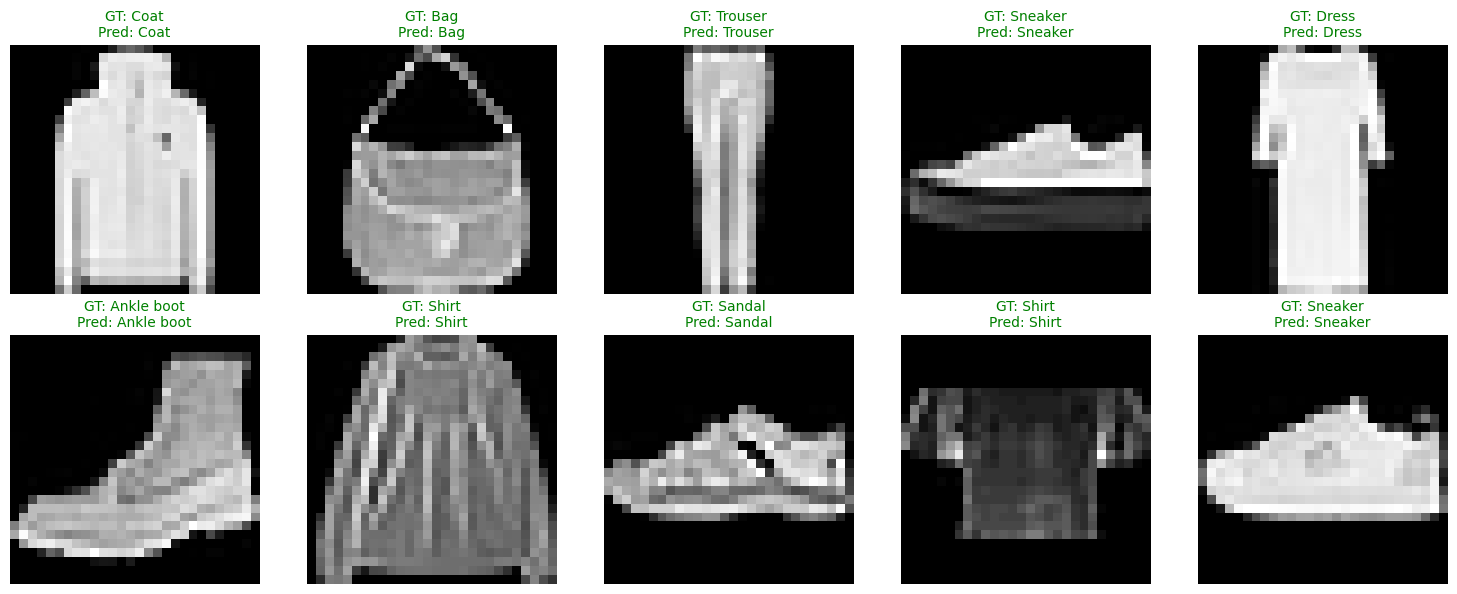

In [ ]:
import matplotlib.pyplot as plt
import random

# Fashion MNIST 클래스 이름 정의
labels_map = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

# 테스트 데이터에서 10개 무작위 샘플 선택
test_images, test_labels = next(iter(DataLoader(f_mnist_test, batch_size=10000)))
indices = random.sample(range(len(test_images)), 10)
samples = [(test_images[i], test_labels[i]) for i in indices]

model.eval()
plt.figure(figsize=(15, 6))

for idx, (img, label) in enumerate(samples):
    ax = plt.subplot(2, 5, idx + 1)
    img_input = img.unsqueeze(0).to(device)  # (1, 1, 28, 28)
    output = model(img_input)
    pred = output.argmax(1).item()

    # 시각화
    plt.imshow(img.squeeze(), cmap="gray")
    ax.set_title(
        f"GT: {labels_map[label.item()]}\nPred: {labels_map[pred]}",
        color=("green" if pred == label.item() else "red"),
        fontsize=10,
    )
    plt.axis("off")

plt.tight_layout()
plt.show()


이번 과제는 단순히 모델 하나를 훈련시키는 수준을 넘어서,
데이터 전처리 → 모델 구성 → Wandb 실험 기록 → 샘플 분석까지 전체 파이프라인을 직접 구축해 보는 좋은 경험이었다
그 과정 속에서 PyTorch 데이터처리 구조, 모델 학습 흐름, 실험 관리 도구의 필요성
을 한 번에 이해할 수 있어 유익했다

특히 Wandb의 실시간 시각화 기능 덕분에
Loss 감소나 Accuracy 향상 패턴을 직관적으로 확인할 수 있어서 만족스러웠다
또한 정규화 파라미터를 직접 계산하여 적용하는 과정은
데이터 기반 접근 방식의 중요성을 다시 한 번 체감하게 해주었다